In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import data
import imodelsx.viz
import joblib
import dvu
import theme_classification
files_dict = data.load_files_dict_single_site()

### Filter data for single-site analysis

In [ ]:
checkpoint = 'gpt-4'
# checkpoint = 'gpt-35-turbo'
# checkpoint = 'mistralai/Mistral-7B-v0.1' # did very poorly

# site = 'Atlanta'
# site = 'Columbus'
site = 'WashingtonDC'
df = files_dict[site]

qs, responses_df, themes_df = data.split_single_site_df(df)

In [ ]:
question, responses, theme_dict = data.get_data_for_question_single_site(
    question_num=8, qs=qs, responses_df=responses_df, themes_df=themes_df)

In [ ]:
llm = imodelsx.llm.get_llm(checkpoint, repeat_delay=3)

# example
# response = responses[1]
# if len(theme_dict) > 1:
#     assert not pd.isna(response)
#     prompt = classification_prompt.format(
#         question=question,
#         classes_as_numbered_list=numbered_list(theme_dict.keys()),
#         response=response,
#     )
#     print(prompt)
# llm(prompt)

In [ ]:
valid_question_nums = theme_classification.get_valid_question_nums(
    qs, responses_df, themes_df)

### Run classification
Note: this uses a lot of calls, num valid questions * num responses = 250

In [43]:
# llm = imodelsx.llm.get_llm(checkpoint, repeat_delay=None)
# valid_question_nums = theme_classification.get_valid_question_nums(
#     qs, responses_df, themes_df)
# classifications = theme_classification.get_classifications(
#     llm, valid_question_nums, qs, responses_df, themes_df)


# iterative version
# ['Atlanta', 'Columbus', 'WashingtonDC']:
for site in ['Charlotte', 'Houston', 'Portland']:
    df = files_dict[site]
    qs, responses_df, themes_df = data.split_single_site_df(df)
    valid_question_nums = theme_classification.get_valid_question_nums(
        qs, responses_df, themes_df)
    classifications = theme_classification.get_classifications(
        llm, valid_question_nums, qs, responses_df, themes_df)
    theme_classification.compute_and_save_eval_mat(classifications, valid_question_nums,
                                                   qs, responses_df, themes_df, site, checkpoint)

100%|██████████| 46/46 [00:00<00:00, 3768.69it/s]


num valid qs 15


100%|██████████| 14/14 [00:00<00:00, 5873.20it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6410.51it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6496.32it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6090.05it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6087.52it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6253.49it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6301.13it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6291.68it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6065.52it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6309.94it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6311.97it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6081.22it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 7130.57it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 14/14 [00:00<00:00, 6238.87it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 15/15 [00:00<00:00, 200.76it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 46/46 [00:00<00:00, 4106.90it/s]


num valid qs 22


100%|██████████| 12/12 [00:00<00:00, 6327.84it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5772.64it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 6094.90it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5881.93it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5850.48it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5647.63it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5787.24it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 2517.84it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 4764.90it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 4509.60it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5904.70it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5888.12it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5947.96it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 6238.43it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 6038.59it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5879.18it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5718.21it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 4451.76it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5387.67it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 12/12 [00:00<00:00, 6676.17it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



 91%|█████████ | 20/22 [00:00<00:00, 198.19it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 12/12 [00:00<00:00, 5320.47it/s]


cached!


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 22/22 [00:00<00:00, 196.81it/s]


cached!


100%|██████████| 46/46 [00:00<00:00, 6029.88it/s]


num valid qs 19


100%|██████████| 11/11 [00:00<00:00, 8000.23it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 6203.76it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5489.93it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5229.81it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4471.11it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5499.74it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!


100%|██████████| 11/11 [00:00<00:00, 4529.93it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5516.18it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5781.62it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5497.78it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5304.97it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5692.45it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 7458.35it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 7457.14it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 6428.50it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 6497.30it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 7361.95it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 11/11 [00:00<00:00, 6331.46it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!



100%|██████████| 19/19 [00:00<00:00, 214.18it/s]


### Make aggregated heatmap

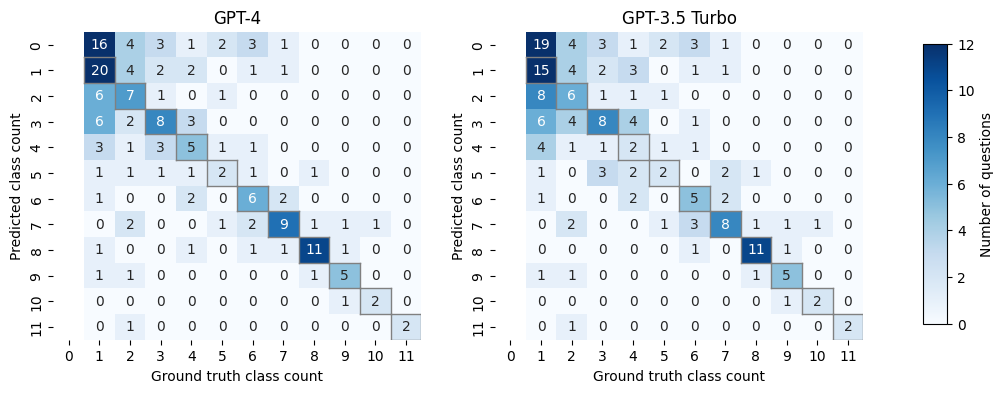

In [47]:
sites = ['Atlanta', 'Columbus', 'WashingtonDC',
         'Charlotte', 'Houston', 'Portland']
checkpoints = ['gpt-4', 'gpt-35-turbo']
vmax = 12

# fig, axes = plt.subplots(1, len(checkpoints), figsize=(len(checkpoints) * 5, 5))
mats = []
for i, checkpoint in enumerate(checkpoints):
    mat = None
    for site in sites:
        try:
            mat_new = joblib.load(join(data.PROCESSED_DIR,
                                       f'classification_confusion_matrix_{site}_{checkpoint.split("/")[-1]}.pkl'))

            # sum mat_new with mat, make size bigger if needed
            if mat is None:
                mat = mat_new
            else:
                mold = mat.shape[0]
                mnew = mat_new.shape[0]
                if mold < mnew:
                    mat_temp = np.zeros((mnew, mnew))
                    mat_temp[:mold, :mold] = mat
                    mat = mat_temp + mat_new
                elif mold > mnew:
                    mat_temp = np.zeros((mold, mold))
                    mat_temp[:mnew, :mnew] = mat_new
                    mat = mat_temp + mat
                else:
                    mat = mat + mat_new
        except:
            print(
                f'Failed to load classification_confusion_matrix_{site}_{checkpoint.split("/")[-1]}.pkl')
    mat[:, 0] = np.nan
    mats.append(mat)


fig, axes = plt.subplots(
    1, len(checkpoints), figsize=(len(checkpoints) * 6, 4))
for i, checkpoint in enumerate(checkpoints):
    mat = mats[i]
    ax = axes[i]
    # mat = mat / np.sum(mat, axis=0)
    sns.heatmap(mat, fmt='g', cmap='Blues',
                vmax=vmax, ax=ax, cbar=False, annot=True)
    # plt.xticks(np.arange(mat.shape[1]) + 0.5, np.arange(np.max(mat.shape[1])) + 1)
    dvu.outline_diagonal(mat.shape, roffset=0.5,
                         coffset=0.5, skip_rows=[0], ax=ax)
    ax.set_ylabel('Predicted class count')
    ax.set_xlabel('Ground truth class count')
    ax.set_title(imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
        checkpoint, checkpoint))
    # plt.savefig(
    # f'../figs/classification_heatmap_{checkpoint.split("/")[-1]}.pdf', bbox_inches='tight')
    # plt.savefig(
    # f'../figs/classification_heatmap_{checkpoint.split("/")[-1]}.png', bbox_inches='tight', dpi=300)

# add colorbar separately
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(axes[0].collections[0], cax=cbar_ax, label='Number of questions')

plt.savefig('../figs/theme_classification.pdf', bbox_inches='tight')
plt.savefig('../figs/theme_classification.png',
            bbox_inches='tight', dpi=300)
plt.show()